In [6]:
import os
import sys; sys.path.append("~/HHbbgg_ETH_devel/bregression/python") # to load packages
import training_utils as utils
import numpy as np
reload(utils)
import preprocessing_utils as preprocessing
reload(preprocessing)
import plotting_utils as plotting
reload(plotting)
import optimization_utils as optimization
reload(optimization)
import postprocessing_utils as postprocessing
reload(postprocessing)


<module 'postprocessing_utils' from '/mnt/t3nfs01/data01/shome/nchernya/HHbbgg_ETH_devel/bregression/python/postprocessing_utils.pyc'>

In [7]:
ntuples = 'heppy_05_10_2017'
# "%" sign allows to interpret the rest as a system command
%env data=$utils.IO.ldata$ntuples
files = ! ls $data | sort -t_ -k 3 -n

ttbar= [s for s in files if "20trees_safe" in s] #large statistics
#ttbar= [s for s in files if "ttbar_RegressionPerJet.root" in s] # only limited statistics


utils.IO.add_target(ntuples,ttbar,1)
utils.IO.add_features(ntuples,ttbar,1)

for i in range(len(utils.IO.targetName)):        
    print "using target file n."+str(i)+": "+utils.IO.targetName[i]
for i in range(len(utils.IO.featuresName)):        
    print "using features file n."+str(i)+": "+utils.IO.featuresName[i]

env: data=/mnt/t3nfs01/data01/shome/nchernya/HHbbgg_ETH_devel/root_files/heppy_05_10_2017
using target file n.0: /mnt/t3nfs01/data01/shome/nchernya/HHbbgg_ETH_devel/root_files/heppy_05_10_2017/ttbar_RegressionPerJet_heppyregression_20trees_safe.root
using features file n.0: /mnt/t3nfs01/data01/shome/nchernya/HHbbgg_ETH_devel/root_files/heppy_05_10_2017/ttbar_RegressionPerJet_heppyregression_20trees_safe.root


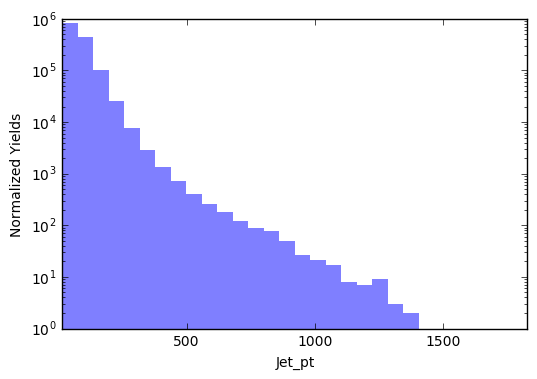

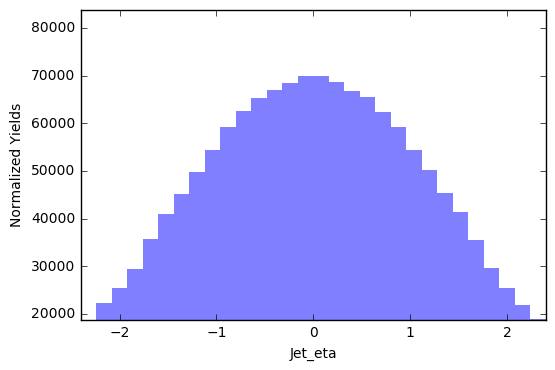

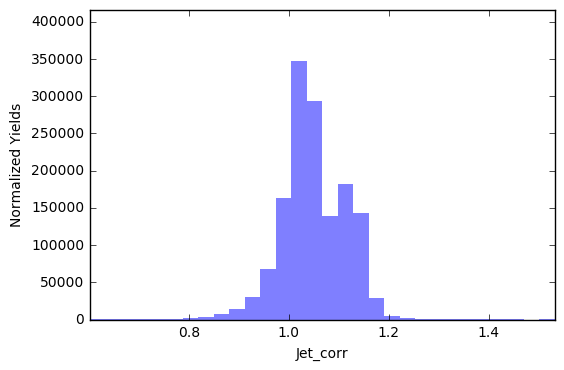

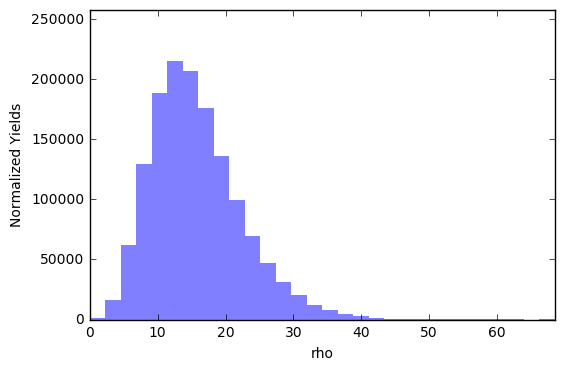

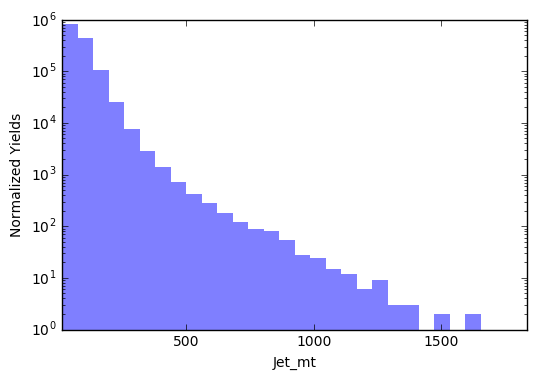

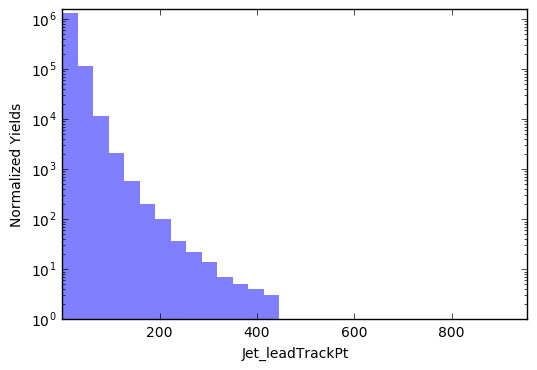

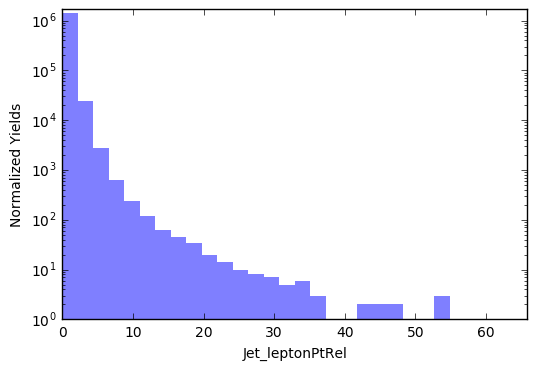

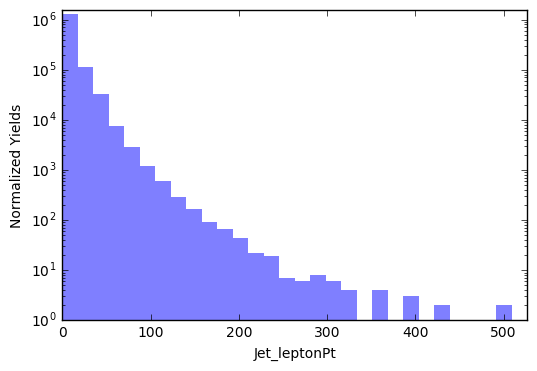

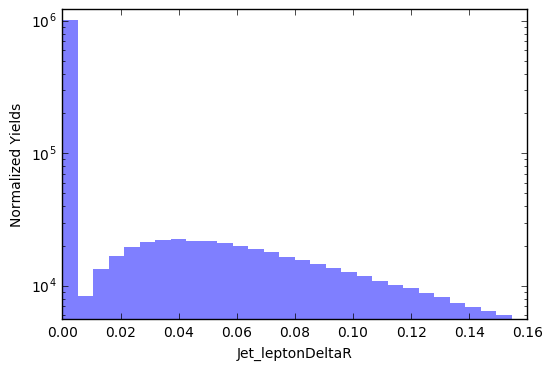

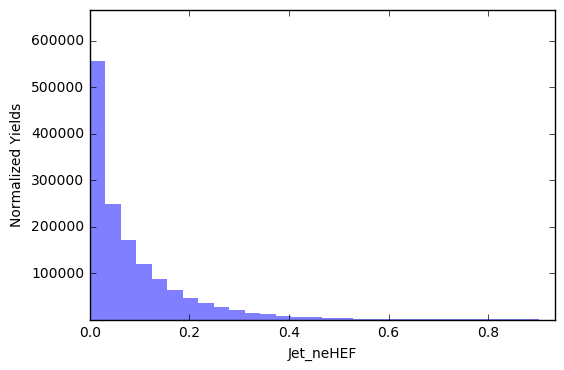

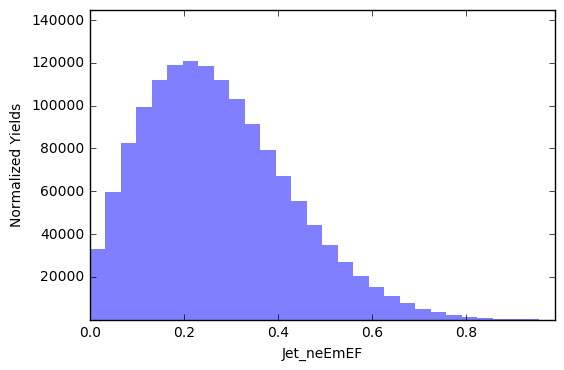

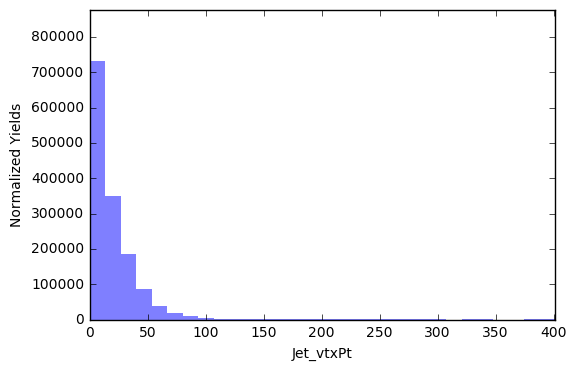

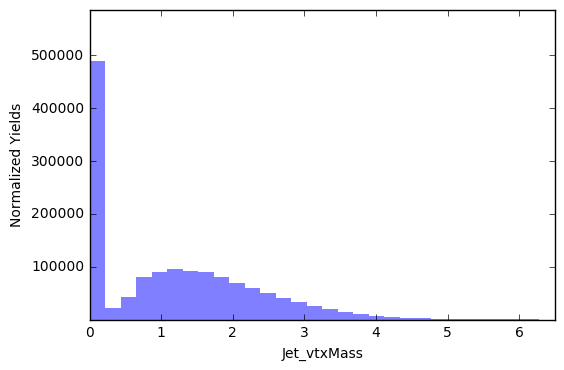

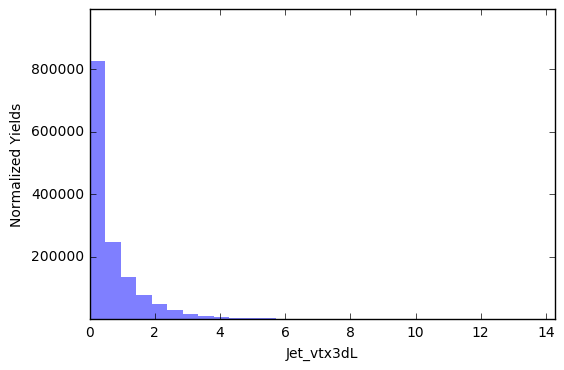

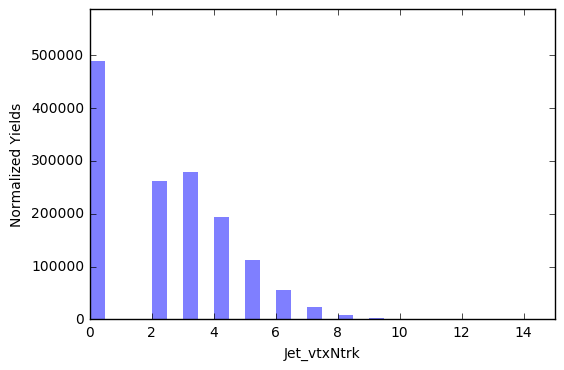

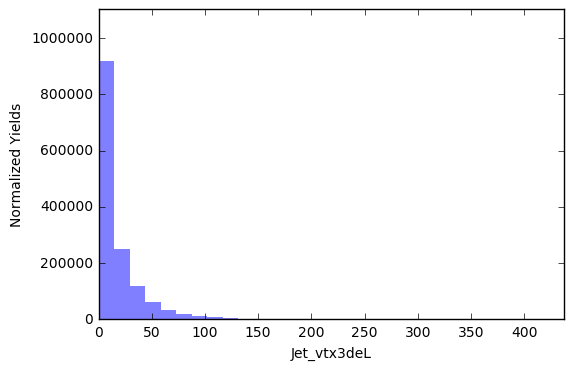

In [8]:
#use noexpand for root expressions, it needs this file https://github.com/ibab/root_pandas/blob/master/root_pandas/readwrite.py
#noexpand:fabs(CosThetaStar_CS)
branch_names = 'Jet_pt,Jet_eta,Jet_corr,Jet_mcPt,Jet_mcFlavour,dR,rho,Jet_mt,Jet_leadTrackPt,Jet_leptonPtRel,Jet_leptonPt,Jet_leptonDeltaR,Jet_neHEF,Jet_neEmEF,Jet_chMult,Jet_vtxPt,Jet_vtxMass,Jet_vtx3dL,Jet_vtxNtrk,Jet_vtx3deL'.split(",")

features = 'Jet_pt,Jet_eta,Jet_corr,rho,Jet_mt,Jet_leadTrackPt,Jet_leptonPtRel,Jet_leptonPt,Jet_leptonDeltaR,Jet_neHEF,Jet_neEmEF,Jet_vtxPt,Jet_vtxMass,Jet_vtx3dL,Jet_vtxNtrk,Jet_vtx3deL'.split(",")
target = 'Jet_mcPt'.split(",")
#cuts='Jet_mcPt > 20 and dR < 0.35 and (Jet_mcFlavour==5 or Jet_mcFlavour==-5) and Jet_pt > 15'
cuts='(Jet_mcPt > 20) & (Jet_mcFlavour==5 | Jet_mcFlavour==-5) & (Jet_pt > 15) & (Jet_eta<2.4 & Jet_eta>-2.4) & (dR < 0.4)'




branch_names = [c.strip() for c in branch_names]
features = [c.strip() for c in features]
target = [c.strip() for c in target]

#print branch_names

import pandas as pd
import root_pandas as rpd

X_features = preprocessing.set_features("tree",branch_names,features,cuts)
X_target = preprocessing.set_target("tree",branch_names,target,cuts)
X_features,X_target=preprocessing.randomize_ft(X_features,X_target)

#print max(X_features[:,1])

#print pd.DataFrame(utils.IO.features_df[0],columns=['Jet_eta'])

X_train_target = preprocessing.get_training_sample(pd.DataFrame(X_target))
X_train_features = preprocessing.get_training_sample(pd.DataFrame(X_features))

X_test_target = preprocessing.get_test_sample(pd.DataFrame(X_target))
X_test_features = preprocessing.get_test_sample(pd.DataFrame(X_features))

#X_target_data =  pd.DataFrame(utils.IO.data_df[0],columns=['Jet_mcPt'])
#X_data_target = utils.IO.data_df[0][['Jet_mcPt']]
#new_jet_mcPt = jet_mcPt.query('Jet_mcPt > 30')

from sklearn.externals import joblib
import xgboost as xgb
import matplotlib.pyplot as plt

log_names='Jet_pt,Jet_mt,Jet_leadTrackPt,Jet_leptonPtRel,Jet_leptonPt,Jet_leptonDeltaR'.split(",")
plotting.plot_input_variables_reg(X_features,features,log_names)
plt.show()


In [9]:
########final optimization with all fixed#######

from sklearn.externals import joblib
import xgboost as xgb
from sklearn.metrics import confusion_matrix, mean_squared_error

#clf = xgb.XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
     #  gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
     #  min_child_weight=1e-05, missing=None, n_estimators=1500, nthread=20,
     #  objective='reg:linear', reg_alpha=0, reg_lambda=0.1,
     #  scale_pos_weight=1, seed=0, silent=True, subsample=1)

clf = xgb.XGBRegressor(objective='reg:linear')
clf.fit(X_train_features,X_train_target)
joblib.dump(clf, os.path.expanduser('~/HHbbgg_ETH_devel/bregression/output_files/regression_heppy_mcPt_cuts.pkl'), compress=9)
predictions = clf.predict(X_test_features)
print predictions, predictions.shape
actuals = X_test_target
true = (actuals.as_matrix()).ravel()
recoPt = (X_test_features[0].as_matrix()).ravel()
#print true, true.shape
#print true[0]/predictions[0]
ratio = true/predictions
ratio=1/ratio
reco_ratio=true/recoPt
reco_ratio=1./reco_ratio
#print ratio.shape
#print ratio


#print(mean_squared_error(actuals, predictions))
#print type(actuals), type(predictions)



[ 81.96308136  35.2899971   51.86930466 ...,  39.998909    40.11634445
  95.94099426] (714430,)
[ 81.95749664  30.70601082  54.46120071 ...,  36.28068161  26.44841957
  91.20645905] (714430,)
0.999932
(714430,)
[ 1.00006819  1.14928627  0.95240837 ...,  1.10248506  1.51677656
  1.05191004]


In [11]:
import matplotlib.pyplot as plt
import ROOT
from ROOT import *


print len(ratio)
print predictions.shape
n, bins, patches = plt.hist(ratio, 40, range=(0,4),normed=0, facecolor='g', alpha=0.75,label='regressed')
n2, bins2, patches2 = plt.hist(reco_ratio, 40, range=(0,4),normed=0, facecolor='r', alpha=0.75,label='reco')

plt.grid(True)
plt.ylabel('Events')
plt.xlabel('$p_{T}/p_T true$')

#plt.show()



gROOT.Reset()
c1 = TCanvas( 'c1', '', 200, 10, 700, 500 )
c1.SetGridx()
c1.SetGridy()




hratio = TH1D("ratio", "ratio", 400, 0, 4)
for i in xrange(len(ratio)): 
    hratio.Fill(ratio[i])
hreco_ratio = TH1D("reco_ratio", "reco_ratio", 400, 0, 4)
for i in xrange(len(reco_ratio)): 
    hreco_ratio.Fill(reco_ratio[i]) 
hratio.Draw()
hreco_ratio.Draw("same")
c1.Update()
c1.SaveAs("test_mcPT.png")
print hratio.GetMean(), hreco_ratio.GetMean()
print hratio.GetRMS(), hreco_ratio.GetRMS()

c2 = TCanvas( 'c2', '', 200, 10, 700, 500 )
c2.SetGridx()
c2.SetGridy()
htrue = TH1D("htrue", "htrue", 50, 0, 400)
for i in xrange(len(true)): 
    htrue.Fill(recoPt[i])

hpred = TH1D("hpred", "hpred", 50, 0, 400)
for i in xrange(len(predictions)): 
    hpred.Fill(predictions[i])    
    
hpred.Divide(htrue)    
hpred.Draw()
c2.SaveAs('pred_true_mcPt.png')

#plotting.plot_classifier_output(clf,X_total_train,X_total_test,y_total_train,y_total_test,outString="xbrg_resWeight_optimized_noDR_minDRGJet_dijetMass")
#plt.show()
#fpr_gJets_2ndtest_2,tpr_gJets_2ndtest_2 = plotting.plot_roc_curve_multiclass_singleBkg(X_total_test,y_total_test,clf,-2,outString="xgbr_gJets_resWeighting_optimized_noDR_minDRGJet_withDR_dijetMass",weights=w_total_test)
#plt.show()
#fpr_dipho_2ndtest_2,tpr_dipho_2ndtest_2 = plotting.plot_roc_curve_multiclass_singleBkg(X_total_test,y_total_test,clf,-1,outString="xgbr_diphotons_resWeighting_optimized_noDR_minDRGJet_withDR_dijetMass",weights=w_total_test)
#plt.show()

714430
<type 'numpy.ndarray'>


TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: c1
TROOT::Append:0: RuntimeWarning: Replacing existing TH1: ratio (Potential memory leak).
TROOT::Append:0: RuntimeWarning: Replacing existing TH1: reco_ratio (Potential memory leak).


1.04057833696 0.9437866403
0.201147072186 0.193589794434


TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: c2
TROOT::Append:0: RuntimeWarning: Replacing existing TH1: htrue (Potential memory leak).
TROOT::Append:0: RuntimeWarning: Replacing existing TH1: hpred (Potential memory leak).
Info in <TCanvas::Print>: png file test_mcPT.png has been created
Info in <TCanvas::Print>: png file pred_true_mcPt.png has been created
